In [90]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from random import sample 
import pickle
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
RSEED = 50

# Load Original Features

In [21]:
feat_num = 457
#df_total = pd.read_csv('./data/features%s.csv'%(feat_num))
with open('./data/features%s.pickle'%(feat_num), 'rb') as handle:
    df_total = pickle.load(handle)

In [22]:
df_train = df_total[df_total['isFraud'].notnull()]
df_train.shape

(590540, 457)

# Sample Train Data

In [23]:
df_train_sample=df_train.sample(n=200000,random_state=RSEED)
df_train_sample.shape

(200000, 457)

# Prepare Data

In [51]:
labels_train = df_train_sample['isFraud']
features_train = df_train_sample.drop(columns = ['isFraud', 'TransactionID'])
features_train.shape

(200000, 455)

In [52]:
categorical_raw = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version',
               'is_card_freq_Device','is_wide','is_long','is_zero','is_win8_vista',
               'is_windows_otheros','is_card_freq_pdc','is_card_freq_addr1'] 

ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical_raw = categorical_raw + ids

In [50]:
#categorical = list(set(categorical_raw).intersection(features_train.columns))
#features_train[categorical].nunique().sort_values(ascending=False)

# Select Features

In [53]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'num_threads':5
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

In [33]:
def train_selector(params,train_num,features_train,labels_train,categorical,verbose_eval=500):
    train_set = lgb.Dataset(features_train.iloc[0:train_num,:], label=labels_train.values[0:train_num],
                       categorical_feature=categorical)
    valid_set = lgb.Dataset(features_train.iloc[train_num:,:], label=labels_train.values[train_num:],
                       categorical_feature=categorical)
    valid_results = {}
    model = lgb.train(params,train_set,num_boost_round = 10000, 
                   valid_sets = [train_set, valid_set],
                    verbose_eval= verbose_eval,
                    early_stopping_rounds = 500,
                    evals_result=valid_results)
    return model,valid_results

In [10]:
def select_by_importance(model,features_train,importance=0,num_keep=None):
    fi = pd.DataFrame({'feature': features_train.columns, 
                   'importance':model.feature_importance()})
    fi = fi.sort_values('importance', ascending = False)
    if num_keep != None:
        to_drop = fi.iloc[num_keep:,:].feature
    else:
        to_drop = fi[fi.importance <= importance].feature
    return to_drop
    

In [11]:
def fold_train_selector(Nfold,features_train,labels_train,categorical):
    splits = Nfold
    ave_auc = 0
    valid_results = {}
    
    folds = KFold(n_splits = splits,random_state=RSEED)
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
        
        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                       evals_result=valid_results)
        

        pred = clf.predict(valid_df)
        auc_score = roc_auc_score(y_valid_df, pred)
        ave_auc += auc_score / splits
        print( "  auc = ", auc_score )
    return ave_auc

In [12]:
def fold_select_feature(Nfold,features_train,labels_train,categorical,importance=0):
    splits = Nfold
    ave_auc = 0
    valid_results = {}
    to_drop=[]
    
    folds = KFold(n_splits = splits,random_state=RSEED)
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
        
        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                       evals_result=valid_results)
        
        drop_this_round = list(select_by_importance(clf,train_df,importance=importance))
        print(drop_this_round)
        
        if fold_num == 0:
            to_drop = drop_this_round
        else:
            to_drop = list(set(to_drop).intersection(drop_this_round))
        print(to_drop)
        
        pred = clf.predict(valid_df)
        auc_score = roc_auc_score(y_valid_df, pred)
        ave_auc += auc_score / splits
        print( "  auc = ", auc_score )
    
    return ave_auc,to_drop
    
    

In [58]:
def permutation_importance(model,features_valid,labels_valid):
    """calculate permutation importance of features
    Args:
        model: the trained model.
        features_valid: dataframe. The validation set of features.
        labels_valid: labels of validation set.
    Returns:
        df_fimportance: dataframe. The importances of features.
    """
    base_score = roc_auc_score(labels_valid, model.predict(features_valid))
    list_fimportance = []
    for col in features_valid.columns:
        print(col)
        save = features_valid[col].copy()
        features_valid[col] = np.random.permutation(features_valid[col])
        col_score = roc_auc_score(labels_valid, model.predict(features_valid))
        features_valid[col] = save
        list_fimportance.append([col,base_score - col_score])
    return pd.DataFrame(list_fimportance,columns = ['feature','importance']) 
    

## PCA V Features

In [88]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    axis: int. 0 means column and 1 means row
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['missing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='missing_percent',ascending = False) 

In [83]:
vfeatures = ['V'+str(i) for i in range(1,340)]

In [89]:
check_missing(features_train[vfeatures],cols=None,axis=0)

,missing_num,missing_percent
V142,172382,86.1910
V149,172382,86.1910
V157,172382,86.1910
V156,172382,86.1910
V155,172382,86.1910
...,...,...
V307,3,0.0015
V308,3,0.0015
V309,3,0.0015
V310,3,0.0015


In [106]:
scaler = StandardScaler()
scaler.fit(features_train[vfeatures])
imp = Imputer(missing_values=np.nan , strategy='mean', axis=0)
vfeature_impute = imp.fit_transform(features_train[vfeatures])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [107]:
vfeature_impute_scale = scaler.transform(vfeature_impute)
vfeature_impute_scale = pd.DataFrame(vfeature_impute_scale, columns=vfeatures)

In [108]:
pca = PCA()
vfeature_pca = pca.fit_transform(vfeature_impute_scale)

In [109]:
# check components number should be the same as total features
components_total = len(pca.explained_variance_ratio_)
# generate sequence for plotting
components = np.arange(components_total)

Text(0.5,1,'Cumulative Explained Variance vs No. of Principal Components')

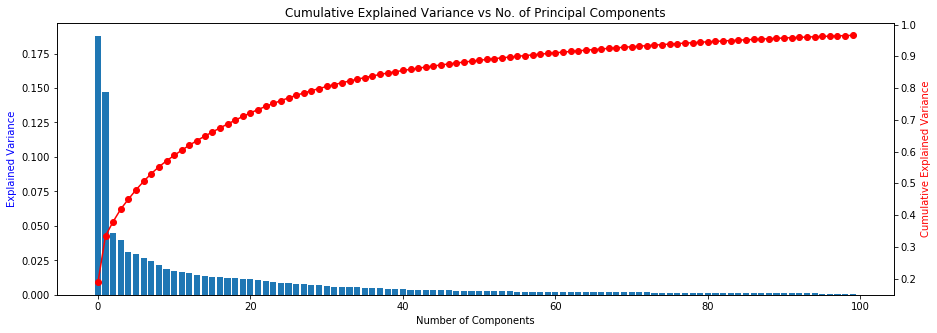

In [114]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.bar(components[0:100],pca.explained_variance_ratio_[0:100])
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_[0:100]), color="red",marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Cumulative Explained Variance vs No. of Principal Components")

In [116]:
np.cumsum(pca.explained_variance_ratio_[:60])[-1]

0.9087414870040146

In [121]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_60 = PCA(n_components=60)
vfeature_pca_60 = pca_60.fit_transform(vfeature_impute_scale)
vfeature_pca_60_df = pd.DataFrame(vfeature_pca_60,columns= ['PCA'+str(i) for i in range(1,61)])

In [122]:
vfeature_pca_60_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59,PCA60
0,-0.989156,-2.226801,-0.018494,0.525162,-2.934965,-0.202245,0.926353,0.015712,1.389273,0.546973,...,0.150241,-0.051675,0.170977,-0.110816,0.057767,0.103398,-0.045202,-0.143065,0.009810,-0.009107
1,-0.857013,-2.256714,-0.702595,-0.285533,-2.148713,1.467795,2.097781,-1.888455,-0.189245,1.214137,...,0.003394,0.006883,0.549933,0.165965,0.199427,-0.032933,-0.012280,0.698466,-0.277903,-0.047135
2,-0.792732,0.664346,-0.960204,-0.625495,-0.265246,0.253286,-0.057415,0.275560,0.272951,0.687692,...,-0.192825,0.120215,-0.032901,0.002937,-0.007769,-0.045886,0.099938,0.016459,-0.011454,-0.013585
3,-0.989156,-2.226801,-0.018494,0.525162,-2.934965,-0.202245,0.926353,0.015712,1.389273,0.546973,...,0.150241,-0.051675,0.170977,-0.110816,0.057767,0.103398,-0.045202,-0.143065,0.009810,-0.009107
4,1.479385,14.576917,-2.105396,-0.175173,0.202288,1.768198,-0.209558,0.754953,0.309545,-0.382658,...,0.567107,0.746644,-0.167409,0.238091,-0.454191,0.170899,0.557590,-0.213023,0.325054,0.014967


In [ ]:
features_train.drop(vfeatures,axis=1,inplace=True)

## Train with all feature set

In [54]:
train_num = 160000
features_train = features_train.drop(['C8'],axis=1)
categorical = list(set(categorical_raw).intersection(features_train.columns))
model,valid_results = train_selector(params,train_num,features_train,labels_train,
                                     categorical,verbose_eval=500)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.995771	valid_1's auc: 0.940221
[1000]	training's auc: 0.999905	valid_1's auc: 0.949917
[1500]	training's auc: 1	valid_1's auc: 0.95239
[2000]	training's auc: 1	valid_1's auc: 0.952922
Early stopping, best iteration is:
[1742]	training's auc: 1	valid_1's auc: 0.952854


In [56]:
model.num_trees()

1742

## Permutation Importance

In [ ]:
fi_importance = permutation_importance(model,features_train.iloc[160000:],
                                       labels_train.iloc[160000:])

In [81]:
fi_importance.sort_values(by='importance',ascending=False)[0:50]

,feature,importance
4,card2,0.012705
9,addr1,0.006663
24,C13,0.006573
13,C1,0.004514
25,C14,0.004220
0,TransactionDT,0.003639
3,card1,0.002957
428,P_email,0.002266
434,pdc_amt_ratio,0.002205
433,hour,0.001524


In [64]:
#fi_importance[fi_importance.importance <0].feature
fi_importance.sort_values(by='importance',ascending=False)[-50:]

,feature,importance
422,id_36,-0.000026
344,V295,-0.000027
367,V318,-0.000027
329,V280,-0.000027
131,V82,-0.000028
328,V279,-0.000029
127,V78,-0.000029
130,V81,-0.000031
300,V251,-0.000031
243,V194,-0.000031


In [61]:
#fi_importance[fi_importance.importance <0].feature
fi_importance.sort_values(by='importance',ascending=False)

,feature,importance
4,card2,0.013591
9,addr1,0.007735
25,C13,0.006005
13,C1,0.003448
0,TransactionDT,0.003235
26,C14,0.003068
429,P_email,0.001935
435,pdc_amt_ratio,0.001697
3,card1,0.001531
434,hour,0.001501


In [25]:
fi_importance.sort_values('importance')[0:50]

,feature,importance
367,V317,-0.000341
20,C8,-0.000169
140,V90,-0.000155
368,V318,-0.000152
426,DeviceType,-0.000151
141,V91,-0.000128
56,V6,-0.000117
152,V102,-0.000115
16,C4,-0.000111
177,V127,-0.000106


## BenchMark Result

In [65]:
categorical = list(set(categorical_raw).intersection(features_train.columns))
#ave_auc,to_drop = fold_select_feature(3,features_train,labels_train,categorical,importance=0)
ave_auc = fold_train_selector(3,features_train,labels_train,categorical)

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.996347	valid_1's auc: 0.936433
[1000]	training's auc: 0.999949	valid_1's auc: 0.94604
[1500]	training's auc: 1	valid_1's auc: 0.948089
[2000]	training's auc: 1	valid_1's auc: 0.948929
Early stopping, best iteration is:
[1633]	training's auc: 1	valid_1's auc: 0.948354
  auc =  0.9483535839723831
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.996917	valid_1's auc: 0.932536
[1000]	training's auc: 0.999962	valid_1's auc: 0.941985
[1500]	training's auc: 1	valid_1's auc: 0.943973
[2000]	training's auc: 1	valid_1's auc: 0.944471
Early stopping, best iteration is:
[1679]	training's auc: 1	valid_1's auc: 0.944256
  auc =  0.9442556451764224
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.996365	valid_1's auc: 0.933419
[1000]	training's auc: 0.999942	valid_1's auc: 0.942804
[1500]	training's auc: 1	valid_1's auc: 0.944883
[2000]	training's auc: 1	valid_1's auc: 0.945407
Early stopping, best iteration is:
[1631]	training's auc: 1	valid_1's auc: 0.945148
  auc =  0.9451476777566561


In [68]:
# feat 456
ave_auc

0.9459189689684873

In [63]:
# feat 457
ave_auc

0.9461316910191324

In [21]:
# feat 476
ave_auc

0.9457859715571262

## Feature selection by Importance

In [78]:
#to_drop = list(select_by_importance(model,features_train,importance=0))
#to_drop = fi_importance[fi_importance.importance <0].feature
to_drop = ['D9']

In [79]:
features_train_temp = features_train.drop(to_drop,axis=1)
categorical_temp = list(set(categorical_raw).intersection(features_train_temp.columns))
ave_auc = fold_train_selector(3,features_train_temp,labels_train,categorical_temp)

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.996392	valid_1's auc: 0.936322
[1000]	training's auc: 0.999944	valid_1's auc: 0.945575
[1500]	training's auc: 1	valid_1's auc: 0.94773
[2000]	training's auc: 1	valid_1's auc: 0.948412
Early stopping, best iteration is:
[1597]	training's auc: 1	valid_1's auc: 0.947932
  auc =  0.9479318648485789
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.997029	valid_1's auc: 0.932007
[1000]	training's auc: 0.99996	valid_1's auc: 0.941922
[1500]	training's auc: 1	valid_1's auc: 0.943769
[2000]	training's auc: 1	valid_1's auc: 0.944145
Early stopping, best iteration is:
[1712]	training's auc: 1	valid_1's auc: 0.944142
  auc =  0.9441424518705119
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.99636	valid_1's auc: 0.933594
[1000]	training's auc: 0.999936	valid_1's auc: 0.942593
[1500]	training's auc: 1	valid_1's auc: 0.944826
[2000]	training's auc: 1	valid_1's auc: 0.945345
Early stopping, best iteration is:
[1732]	training's auc: 1	valid_1's auc: 0.945217
  auc =  0.9452174170364261


In [71]:
# drop 'V102'
ave_auc

0.9458038011328773

In [74]:
# drop 'C10'
ave_auc

0.94576481260304

In [77]:
# drop 'V29'
ave_auc

0.9458355844693852

In [80]:
# drop D9
ave_auc

0.945763911251839

In [44]:
with open('./data/feat476_rm_pm_importance0.pickle', 'wb') as handle:
    pickle.dump(to_drop, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Recursive Eliminate Features

In [ ]:
best = 0.9531365218167643
rm_col = ''
for col in categorical:
    print(col)
    features_train_temp = features_train.drop(col,axis=1)
    categorical_temp = list(set(categorical_raw).intersection(features_train_temp.columns))
    model_temp,valid_results = train_selector(params,train_num,features_train_temp,labels_train,categorical_temp,verbose_eval=2000)
    pfm = max(valid_results['valid_1']['auc'])
    if pfm > best:
        print('remove %s improve auc from %s to %s this feature is endanger'%(col,best,pfm))
        best = pfm
        rm_col = col
        